In [1]:
import numpy as np
import pandas as pd
import torch
import os

from scipy.stats import wasserstein_distance
from itertools import combinations

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import ot
import re

def plot_annotated_heatmap(df, cmap="coolwarm", fmt=".2f", figsize=(16, 16), cbar_shrink=0.5):
    """
    Plots a heatmap of a square DataFrame with annotated values after setting the diagonal to 0
    and normalizing the matrix so that the sum of all values equals 1.

    Parameters:
        df (pd.DataFrame): A square DataFrame to be plotted.
        cmap (str): Colormap for the heatmap.
        fmt (str): Format string for annotations.
        figsize (tuple): Size of the figure.
        cbar_shrink (float): Factor to shrink the color bar (default is 0.5).
    """
    if df.shape[0] != df.shape[1]:
        raise ValueError("The input DataFrame must be square (same number of rows and columns).")

    df = df.copy()  # Avoid modifying the original DataFrame

    # Set diagonal to 0
    print(1)
    np.fill_diagonal(df.values, 0)

    # Normalize so that the sum of all values is 1
    df /= df.sum().sum()

    plt.figure(figsize=figsize)
    sns.heatmap(df, annot=False, fmt=fmt, cmap=cmap, linewidths=0.5, square=True, cbar=True, 
                cbar_kws={"shrink": cbar_shrink})  # Adjust the color bar size
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.show()

def sanitize_string(s):
    return re.sub(r'[^a-zA-Z0-9\/+&]', '_', s) if isinstance(s, str) else s
    
def sanitize_dataframe(df):

    # Apply sanitization to column names
    df.columns = [sanitize_string(col) for col in df.columns]
    
    # Apply sanitization to row index names
    df.index = [sanitize_string(idx) for idx in df.index]
    
    # Apply sanitization to all string values in the DataFrame
    df = df.applymap(sanitize_string)
    
    return df

def clean_and_sort_dataframe(df):
    """
    Cleans and sorts the row and column names of a given DataFrame.

    - Replaces any character not in [a-zA-Z0-9/+&] with '_'.
    - Sorts both row and column names.

    Parameters:
    df (pd.DataFrame): Input DataFrame.

    Returns:
    pd.DataFrame: Cleaned and sorted DataFrame.
    """
    def clean_name(name):
        return re.sub(r'[^a-zA-Z0-9\/+&]', '_', name) if isinstance(name, str) else name

    # Clean index and columns
    df.index = df.index.map(clean_name)
    df.columns = df.columns.map(clean_name)

    # Sort index and columns
    df = df.sort_index(axis=0).sort_index(axis=1)

    return df

def build_communication_tensor(df, ligand_col, receptor_col, sender_col, receiver_col, strength_col, cell_types):
    """
    Constructs a 3D tensor representing cell type networks for each unique ligand-receptor pair.
    
    Parameters:
    df (pd.DataFrame): Dataframe containing ligand, receptor, sender cell type, receiver cell type, and communication strength.
    ligand_col (str): Column name for ligand.
    receptor_col (str): Column name for receptor.
    sender_col (str): Column name for sender cell type.
    receiver_col (str): Column name for receiver cell type.
    strength_col (str): Column name for communication strength.
    cell_types (list): List of all possible cell types.
    
    Returns:
    np.ndarray: 3D tensor of shape (num_cell_types, num_cell_types, num_ligand_receptor_pairs).
    list: List of unique ligand-receptor pairs in order.
    """
    cell_types=[sanitize_string(i) for i in cell_types]
    
    # Get unique ligand-receptor pairs
    df['ligand_receptor'] = df[ligand_col] + "_" + df[receptor_col]
    unique_pairs = df['ligand_receptor'].unique()
    
    # Sort cell types for consistent matrix ordering
    cell_types = sorted(cell_types)
    num_cell_types = len(cell_types)
    num_pairs = len(unique_pairs)
    
    # Create an index mapping for cell types
    cell_type_idx = {cell: i for i, cell in enumerate(cell_types)}
    
    # Initialize the 3D tensor
    tensor = np.zeros((num_cell_types, num_cell_types, num_pairs))
    
    # Fill the tensor
    for k, pair in enumerate(unique_pairs):
        subset = df[df['ligand_receptor'] == pair]
        for _, row in subset.iterrows():
            sender = row[sender_col]
            receiver = row[receiver_col]
            strength = row[strength_col]
            if sender in cell_type_idx and receiver in cell_type_idx:
                i, j = cell_type_idx[sender], cell_type_idx[receiver]
                tensor[i, j, k] = strength
            else:
                print("wrong",sender,receiver)
    
    return tensor, list(unique_pairs)

In [3]:
def drop_unlabeled(df):
    """
    Remove rows and columns labeled as 'Unlabeled' from a square pandas DataFrame.
    """
    return df.loc[~df.index.isin(["Unlabeled"]), ~df.columns.isin(["Unlabeled"])]

['B_Cells', 'CD4+_T_Cells', 'CD8+_T_Cells', 'DCIS_1', 'DCIS_2', 'Endothelial', 'Invasive_Tumor', 'IRF7+_DCs', 'LAMP3+_DCs', 'Macrophages_1', 'Macrophages_2', 'Mast_Cells', 'Myoepi_ACTA2+', 'Myoepi_KRT15+', 'Perivascular-Like', 'Prolif_Invasive_Tumor', 'Stromal', 'Stromal_&_T_Cell_Hybrid', 'T_Cell_&_Tumor_Hybrid', 'Unlabeled']
['B_Cells', 'CD4._T_Cells', 'CD8._T_Cells', 'DCIS_1', 'DCIS_2', 'Endothelial', 'Invasive_Tumor', 'IRF7._DCs', 'LAMP3._DCs', 'Macrophages_1', 'Macrophages_2', 'Mast_Cells', 'Myoepi_ACTA2.', 'Myoepi_KRT15.', 'Perivascular.Like', 'Prolif_Invasive_Tumor', 'Stromal', 'Stromal_._T_Cell_Hybrid', 'T_Cell_._Tumor_Hybrid', 'Unlabeled']
(20, 20)
1


/tmp/ipykernel_1718442/4014250243.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(sanitize_string)


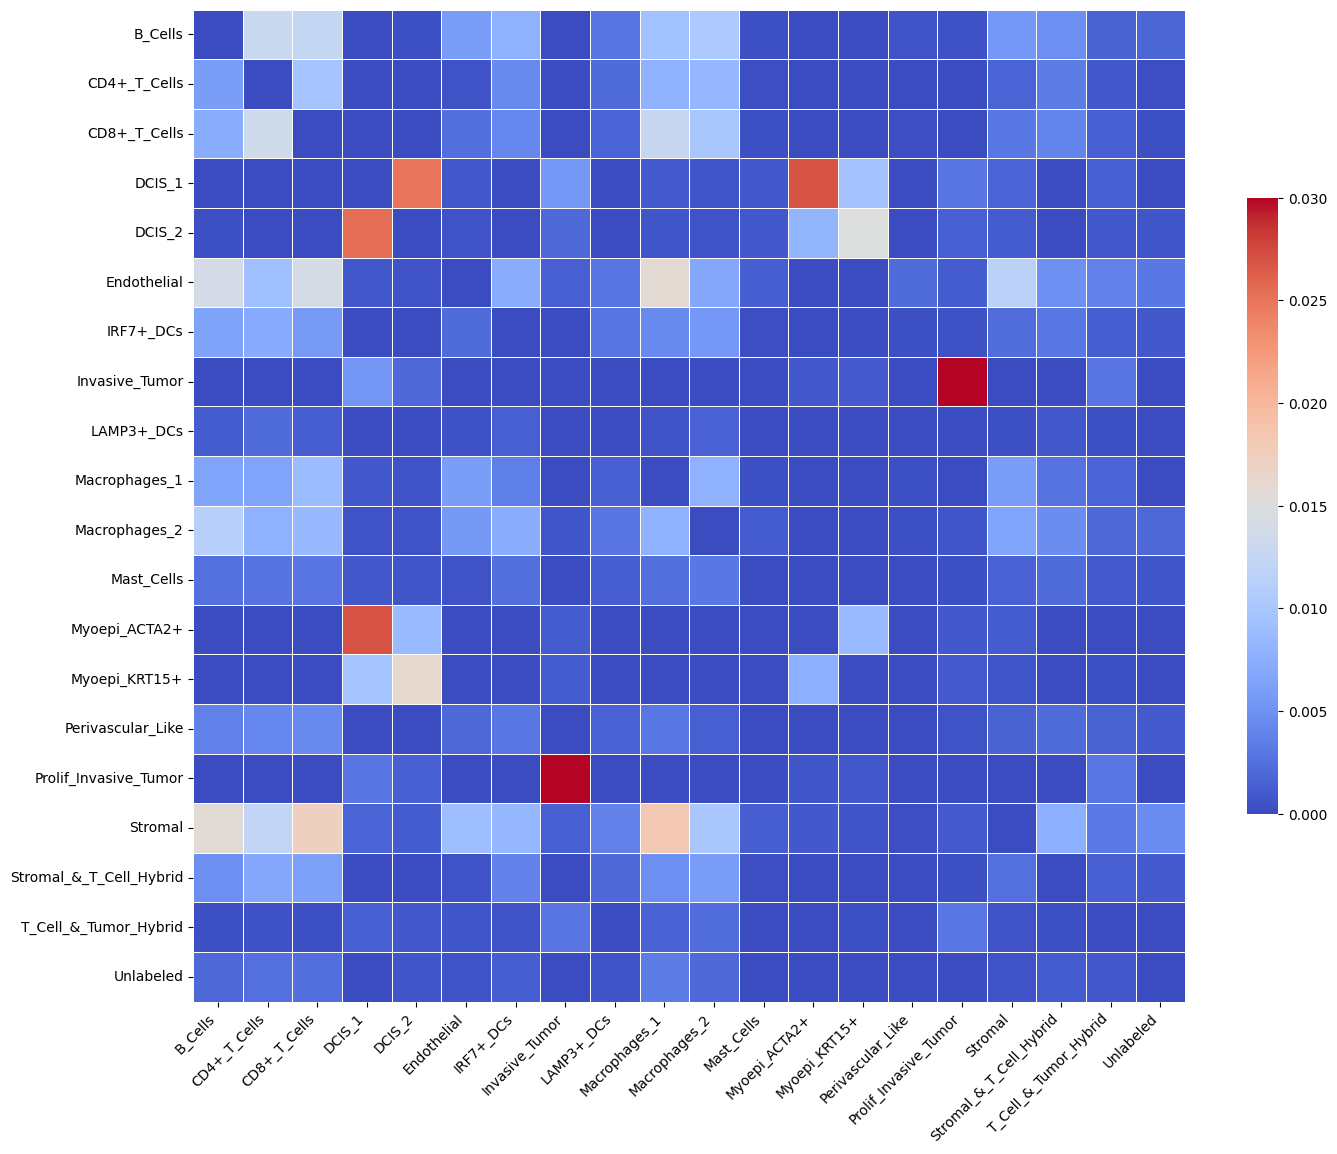

In [23]:
# cellchat
cellchat=pd.read_csv("./CellChat/BC_aggregated.csv",index_col=0)
print(cellchat.index.tolist())
print(cellchat.columns.tolist())
cellchat.columns=cellchat.index.tolist()
cellchat=sanitize_dataframe(cellchat)
cellchat=clean_and_sort_dataframe(cellchat)
print(cellchat.shape)
plot_annotated_heatmap(cellchat)

cellchat=drop_unlabeled(cellchat)

cell_types_BC=cellchat.index.tolist()

['id_cp_interaction', 'interacting_pair', 'partner_a', 'partner_b', 'gene_a', 'gene_b', 'secreted', 'receptor_a', 'receptor_b', 'annotation_strategy', 'is_integrin', 'directionality', 'classification', 'B_Cells|B_Cells', 'B_Cells|CD4+_T_Cells', 'B_Cells|CD8+_T_Cells', 'B_Cells|DCIS_1', 'B_Cells|DCIS_2', 'B_Cells|Endothelial', 'B_Cells|IRF7+_DCs', 'B_Cells|Invasive_Tumor', 'B_Cells|LAMP3+_DCs', 'B_Cells|Macrophages_1', 'B_Cells|Macrophages_2', 'B_Cells|Mast_Cells', 'B_Cells|Myoepi_ACTA2+', 'B_Cells|Myoepi_KRT15+', 'B_Cells|Perivascular-Like', 'B_Cells|Prolif_Invasive_Tumor', 'B_Cells|Stromal', 'B_Cells|Stromal_&_T_Cell_Hybrid', 'B_Cells|T_Cell_&_Tumor_Hybrid', 'B_Cells|Unlabeled', 'CD4+_T_Cells|B_Cells', 'CD4+_T_Cells|CD4+_T_Cells', 'CD4+_T_Cells|CD8+_T_Cells', 'CD4+_T_Cells|DCIS_1', 'CD4+_T_Cells|DCIS_2', 'CD4+_T_Cells|Endothelial', 'CD4+_T_Cells|IRF7+_DCs', 'CD4+_T_Cells|Invasive_Tumor', 'CD4+_T_Cells|LAMP3+_DCs', 'CD4+_T_Cells|Macrophages_1', 'CD4+_T_Cells|Macrophages_2', 'CD4+_T_Cel

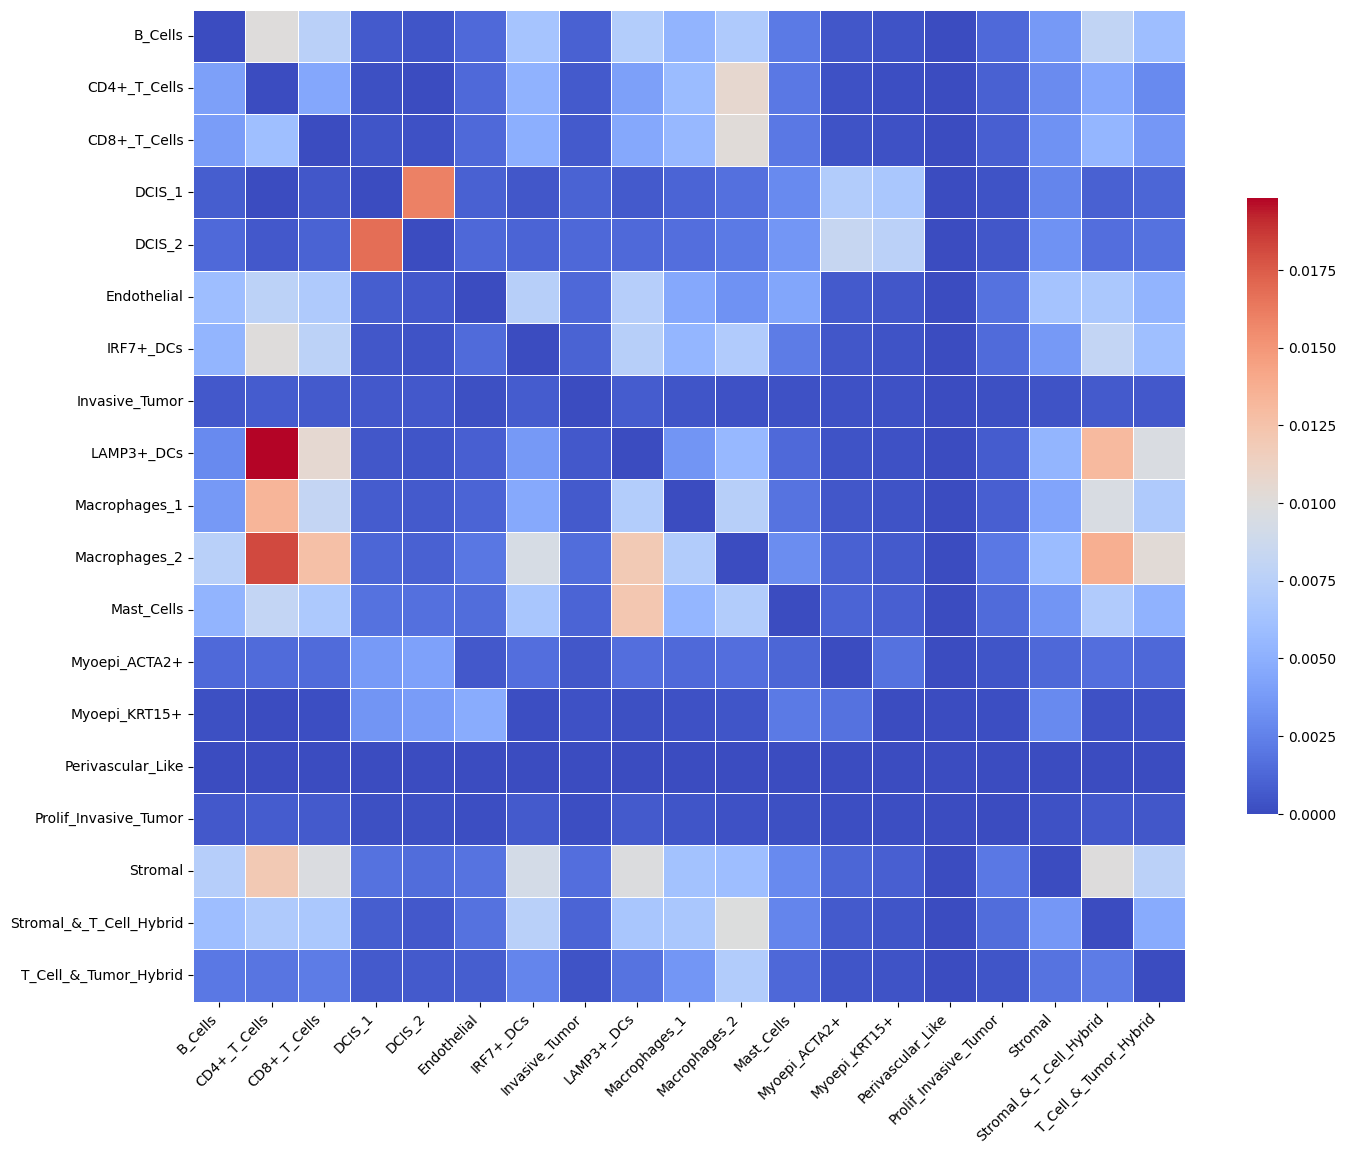

In [24]:
# CellPhoneDB
cellphone_all=torch.load("./CellphoneDB/BC.pth",weights_only=False)
print(cellphone_all['interaction_scores'].columns.tolist())

import pandas as pd
import re

def process_cellphone(df, cell_types):
    # Step 1: Filter columns containing "|"
    filtered_cols = [col for col in df.columns if "|" in col]
    
    if not filtered_cols:
        raise ValueError("No columns found containing '|' in the name.")
    
    # Step 2: Compute row sums for selected columns
    row_sums = df[filtered_cols].sum(axis=1)
    
    # Step 3: Remove rows where the sum is 0
    df_filtered = df[row_sums > 0].copy()

    # Step 4: Normalize remaining rows
    normalized_df = df_filtered[filtered_cols]
    
    # Step 5: Compute the mean across rows for selected columns
    mean_values = normalized_df.mean()
    
    # Step 6: Prepare a square dataframe with sorted cell types
    cell_types = sorted(set(cell_types))  # Ensure unique, sorted cell types
    agg_df = pd.DataFrame(0, index=cell_types, columns=cell_types, dtype=float)

    # Step 7: Aggregate values into a square matrix
    for col, value in mean_values.items():
        parts = col.split("|")
        if len(parts) == 2:
            cell_type_A, cell_type_B = parts
            if cell_type_A in cell_types and cell_type_B in cell_types:
                agg_df.loc[cell_type_A, cell_type_B] += value

    # Step 8: Apply regex-based name formatting
    formatted_index = [re.sub(r'[^a-zA-Z0-9\/+&]', '_', str(idx)) for idx in agg_df.index]
    formatted_columns = [re.sub(r'[^a-zA-Z0-9\/+&]', '_', str(col)) for col in agg_df.columns]
    
    agg_df.index = formatted_index
    agg_df.columns = formatted_columns

    return agg_df
    
cellphone=process_cellphone(cellphone_all['interaction_scores'],cell_types_BC)
cellphone=clean_and_sort_dataframe(cellphone)

cellphone=drop_unlabeled(cellphone)
print(cellphone)
plot_annotated_heatmap(cellphone)

In [14]:
# GITIII
results=torch.load("/vast/palmer/scratch/wang_zuoheng/xx244/GITIII_backup/BC_evaluate/edges/"+"edges_"+"sample1_rep1"+".pth",map_location=torch.device('cpu'))

In [15]:
attention_scores=results["attention_score"]/8
attention_scores=torch.abs(attention_scores)
attention_scores=attention_scores/torch.sum(attention_scores,dim=(0,1),keepdim=True)
attention_scores=torch.mean(attention_scores,dim=-1)
#attention_scores=attention_scores/torch.sum(attention_scores,dim=-1,keepdim=True)
print(attention_scores.shape,attention_scores)

torch.Size([159224, 49]) tensor([[1.5545e-06, 5.9569e-07, 4.6330e-07,  ..., 1.4886e-08, 2.2926e-08,
         1.4915e-08],
        [1.0743e-06, 1.8927e-07, 1.0787e-07,  ..., 1.8086e-08, 5.7069e-08,
         1.7890e-08],
        [8.1149e-07, 7.3008e-07, 9.3261e-07,  ..., 3.9842e-08, 2.2961e-08,
         3.5115e-08],
        ...,
        [5.2520e-07, 4.7792e-07, 1.6218e-07,  ..., 2.5713e-08, 2.5725e-08,
         2.5726e-08],
        [7.8703e-07, 6.7627e-07, 2.3634e-07,  ..., 4.6419e-08, 3.2024e-08,
         3.0796e-08],
        [4.2227e-07, 5.2029e-07, 2.7060e-07,  ..., 2.5415e-08, 2.5418e-08,
         2.5424e-08]])


In [16]:
cell_type_matrix=np.array(results['cell_type_name'])
print(cell_type_matrix.shape)

(159224, 50)


In [17]:
def rename_cell_type(cell_type):
    return re.sub(r'[^a-zA-Z0-9\/+&]', '_', cell_type)

def aggregate_attention_scores(attention_scores, cell_type_matrix):
    """Compute the sum of attention scores for each sender-receiver cell type pair 
    and normalize by the number of receiver cells of each type, ensuring float values."""
    
    # Extract receiver and sender cell types
    receiver_types = cell_type_matrix[:, 0]  # First column: receiver cell type
    sender_types = cell_type_matrix[:, 1:]  # Other columns: sender cell type

    # Flatten data to count interactions
    data = []
    for i in range(attention_scores.shape[0]):
        for j in range(attention_scores.shape[1]):
            data.append((receiver_types[i], sender_types[i, j], float(attention_scores[i, j])))

    df = pd.DataFrame(data, columns=["Receiver", "Sender", "Score"])

    # Compute sum of attention scores for each sender-receiver pair
    sum_scores = df.groupby(["Sender", "Receiver"])["Score"].sum().unstack(fill_value=0)

    # Count the number of receiver cells per receiver type
    receiver_counts = df.groupby("Receiver").size()

    # Normalize by the number of receiver cells per receiver type
    normalized_df = sum_scores.div(receiver_counts, axis=1).fillna(0)

    # Rename cell types
    normalized_df.index = [rename_cell_type(idx) for idx in normalized_df.index]
    normalized_df.columns = [rename_cell_type(col) for col in normalized_df.columns]

    # Aggregate after renaming
    normalized_df = normalized_df.groupby(normalized_df.index).sum()
    normalized_df = normalized_df.groupby(normalized_df.columns, axis=1).sum()
    
    # Sort the dataframe
    sorted_index = sorted(normalized_df.index)
    sorted_columns = sorted(normalized_df.columns)
    normalized_df = normalized_df.loc[sorted_index, sorted_columns]

    # Convert all values to float explicitly
    normalized_df = normalized_df.astype(float)

    return normalized_df

GITIII=aggregate_attention_scores(attention_scores, cell_type_matrix)

/tmp/ipykernel_1718442/3750468502.py:35: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  normalized_df = normalized_df.groupby(normalized_df.columns, axis=1).sum()


(19, 19)
1


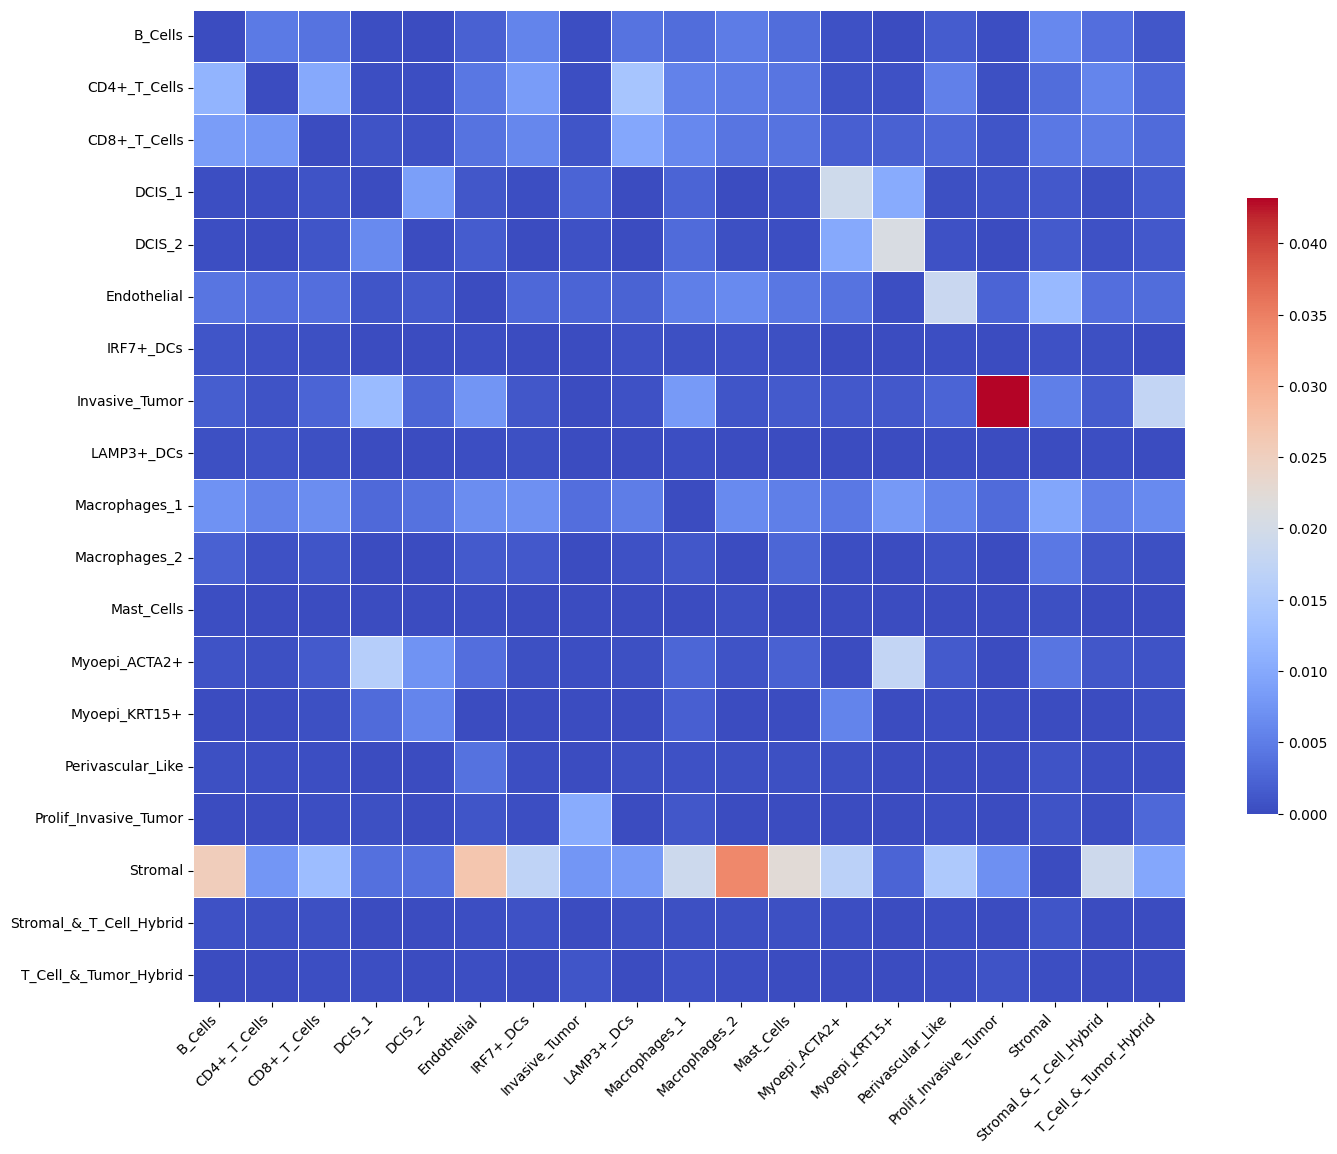

In [18]:
GITIII=drop_unlabeled(GITIII)
print(GITIII.shape)
plot_annotated_heatmap(GITIII)

In [19]:
print(GITIII.index.tolist(),GITIII.columns.tolist())

['B_Cells', 'CD4+_T_Cells', 'CD8+_T_Cells', 'DCIS_1', 'DCIS_2', 'Endothelial', 'IRF7+_DCs', 'Invasive_Tumor', 'LAMP3+_DCs', 'Macrophages_1', 'Macrophages_2', 'Mast_Cells', 'Myoepi_ACTA2+', 'Myoepi_KRT15+', 'Perivascular_Like', 'Prolif_Invasive_Tumor', 'Stromal', 'Stromal_&_T_Cell_Hybrid', 'T_Cell_&_Tumor_Hybrid'] ['B_Cells', 'CD4+_T_Cells', 'CD8+_T_Cells', 'DCIS_1', 'DCIS_2', 'Endothelial', 'IRF7+_DCs', 'Invasive_Tumor', 'LAMP3+_DCs', 'Macrophages_1', 'Macrophages_2', 'Mast_Cells', 'Myoepi_ACTA2+', 'Myoepi_KRT15+', 'Perivascular_Like', 'Prolif_Invasive_Tumor', 'Stromal', 'Stromal_&_T_Cell_Hybrid', 'T_Cell_&_Tumor_Hybrid']


In [20]:
print(GITIII.shape,sorted(GITIII.columns.tolist()))
print(cellphone.shape,sorted(cellphone.columns.tolist()))
print(set(GITIII.columns.tolist())-set(cellphone.columns.tolist()))

(19, 19) ['B_Cells', 'CD4+_T_Cells', 'CD8+_T_Cells', 'DCIS_1', 'DCIS_2', 'Endothelial', 'IRF7+_DCs', 'Invasive_Tumor', 'LAMP3+_DCs', 'Macrophages_1', 'Macrophages_2', 'Mast_Cells', 'Myoepi_ACTA2+', 'Myoepi_KRT15+', 'Perivascular_Like', 'Prolif_Invasive_Tumor', 'Stromal', 'Stromal_&_T_Cell_Hybrid', 'T_Cell_&_Tumor_Hybrid']
(17, 17) ['B_Cells', 'CD4+_T_Cells', 'CD8+_T_Cells', 'DCIS_1', 'DCIS_2', 'Endothelial', 'IRF7+_DCs', 'LAMP3+_DCs', 'Macrophages_1', 'Macrophages_2', 'Mast_Cells', 'Myoepi_ACTA2+', 'Myoepi_KRT15+', 'Perivascular_Like', 'Stromal', 'Stromal_&_T_Cell_Hybrid', 'tumor']
{'Invasive_Tumor', 'T_Cell_&_Tumor_Hybrid', 'Prolif_Invasive_Tumor'}


(19, 19)                            B_Cells  CD4+_T_Cells  CD8+_T_Cells     DCIS_1  \
B_Cells                   0.000000     23.767229     19.612827  31.255640   
CD4+_T_Cells             23.767229      0.000000     17.099348  25.771336   
CD8+_T_Cells             19.612827     17.099348      0.000000  27.354871   
DCIS_1                   31.255640     25.771336     27.354871   0.000000   
DCIS_2                   29.781708     29.606415     29.148305  26.013786   
Endothelial              24.116316     25.951085     24.075274  25.797807   
IRF7+_DCs                19.882527     25.872770     23.152269  38.955552   
Invasive_Tumor           20.488806     20.004294     18.833033  17.063480   
LAMP3+_DCs               24.536312     25.301598     24.901280  37.136818   
Macrophages_1            21.126899     22.905182     20.634661  23.245667   
Macrophages_2            26.817196     34.052338     31.705174  37.897756   
Mast_Cells               25.301149     31.846936     28.957866  37.

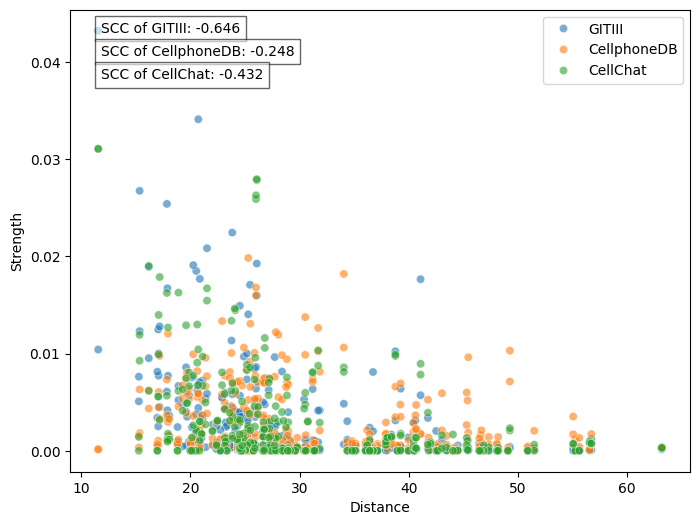

In [25]:
import scipy.stats as stats
#import ace_tools as tools

summary={"GITIII":GITIII.loc[cell_types_BC,cell_types_BC], "CellphoneDB":cellphone.loc[cell_types_BC,cell_types_BC], "CellChat":cellchat.loc[cell_types_BC,cell_types_BC]}

def normalize_dataframe(df):
    """
    Normalize a square dataframe by setting diagonal values to 0 
    and then scaling all values so that their sum equals 1.
    """
    df = df.copy()
    np.fill_diagonal(df.values, 0)  # Set diagonal to 0
    total_sum = df.values.sum()
    if total_sum > 0:
        df /= total_sum  # Normalize to sum to 1
    return df

def extract_and_plot_df_no_diag_scc(data_dict, distance_df):
    """
    Extract non-diagonal elements from normalized squared data dataframes 
    and a single distance dataframe, plot data values against distances 
    with colors representing matrix names, and annotate the Spearman correlation 
    coefficient for each matrix, excluding diagonal values from SCC calculation.

    Parameters:
    - data_dict: dict, keys are matrix names and values are square pandas DataFrames (data values)
    - distance_df: pandas DataFrame, a single square matrix representing distances
    """
    plot_data = []

    if any(mat.shape != distance_df.shape for mat in data_dict.values()):
        raise ValueError("All data dataframes must have the same shape as the distance dataframe")

    if distance_df.shape[0] != distance_df.shape[1]:
        raise ValueError("Distance dataframe is not square")

    # Extract non-diagonal elements
    mask = ~np.eye(distance_df.shape[0], dtype=bool)
    distances = distance_df.values[mask]

    for name, data_df in data_dict.items():
        norm_df = normalize_dataframe(data_df)  # Normalize the data dataframe
        values = norm_df.values[mask]

        # Compute Spearman correlation excluding diagonal values
        spearman_corr, _ = stats.spearmanr(values, distances)

        for v, d in zip(values, distances):
            plot_data.append([name, v, d, spearman_corr])

    # Convert to dataframe
    df = pd.DataFrame(plot_data, columns=["Name", "Value", "Distance", "SpearmanCorr"])

    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x="Distance", y="Value", hue="Name", alpha=0.6)

    # Annotate correlation
    for name in df["Name"].unique():
        subset = df[df["Name"] == name]
        spearman_corr, _ = stats.spearmanr(subset["Value"], subset["Distance"])  # Recalculate without diagonal
        plt.text(0.05, 0.95 - list(df["Name"].unique()).index(name) * 0.05, f"SCC of {name}: {spearman_corr:.3f}",
                 transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

    plt.xlabel("Distance")
    plt.ylabel("Strength")
    plt.legend()
    plt.show()

df_distance=drop_unlabeled(pd.read_csv("./distance/BC.csv",index_col=0))
print(df_distance.shape,df_distance)

extract_and_plot_df_no_diag_scc(summary, df_distance)